# Importing the libraries

In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy.stats import zscore, iqr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import skew, kurtosis, boxcox
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
btc=pd.read_csv('btcusdt_1h_zelta.csv') # file saved in current location
btc

datetime      open      high       low     close  \
0      2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01   
1      2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06   
2      2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18   
3      2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03   
4      2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01   
...                    ...       ...       ...       ...       ...   
35203  2022-01-12 01:30:00  42972.04  43095.26  42692.19  42800.38   
35204  2022-01-12 02:30:00  42797.62  42823.69  42643.74  42659.20   
35205  2022-01-12 03:30:00  42664.71  42776.14  42597.41  42713.13   
35206  2022-01-12 04:30:00  42713.12  42886.28  42633.97  42729.29   
35207  2022-01-12 05:30:00  42729.29  42965.00  42578.02  42675.00   

            volume  
0       443.356199  
1       383.697006  
2       429.064572  
3       420.087030  
4       340.807329  
...            ...  
35203  1219.601780  
35204   702.103800  
35205   561.859930  
35206   681.142010  
35207  1004.906890  

[35208 rows x 6 columns]

# Exploratory Data Analysis

### summary statistics

In [3]:
print(btc.describe())

               open          high           low         close        volume
count  35208.000000  35208.000000  35208.000000  35208.000000  35208.000000
mean   18539.414637  18649.115725  18421.316673  18540.235786   2280.268987
std    17824.522767  17932.147494  17709.969405  17824.970956   2188.271567
min     3172.620000   3184.750000   3156.260000   3172.050000      0.000000
25%     7101.045000   7140.000000   7062.735000   7101.727500   1066.353192
50%     9471.150000   9512.000000   9423.960000   9470.990000   1663.188535
75%    31580.232500  31800.450000  31275.312500  31580.440000   2710.796384
max    68635.120000  69000.000000  68451.190000  68633.690000  47255.762685


### visualising the given data

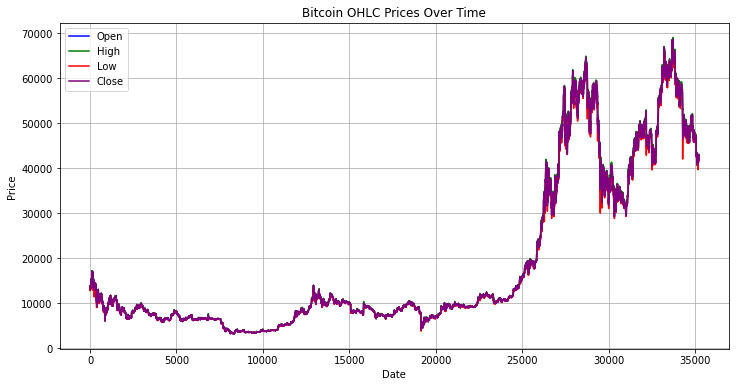

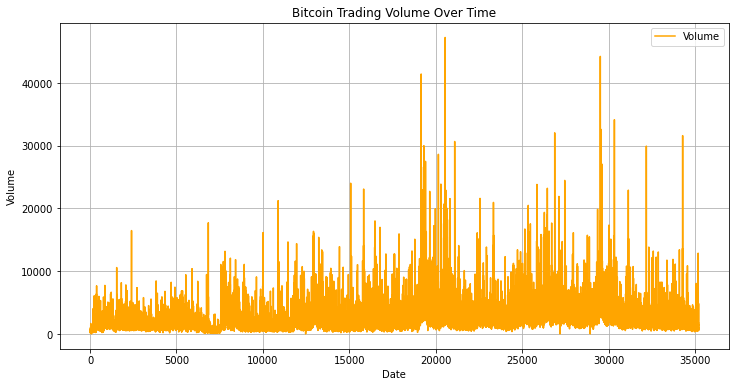

In [4]:
# Plot OHLC prices
plt.figure(figsize=(12, 6))

# Plot open, high, low, and close prices
plt.plot(btc.index, btc['open'], label='Open', color='blue')
plt.plot(btc.index, btc['high'], label='High', color='green')
plt.plot(btc.index, btc['low'], label='Low', color='red')
plt.plot(btc.index, btc['close'], label='Close', color='purple')

# Add labels and legend
plt.title('Bitcoin OHLC Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot trading volume
plt.figure(figsize=(12, 6))

# Plot trading volume
plt.plot(btc.index, btc['volume'], label='Volume', color='orange')

# Add labels and legend
plt.title('Bitcoin Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
fig = go.Figure(data=[go.Candlestick(x=btc['datetime'],
                open=btc['open'],
                high=btc['high'],
                low=btc['low'],
                close=btc['close'])])

fig.update_layout(title='Bitcoin OHLCV Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Price')
fig.show()

### searching for trends in closing prices time series

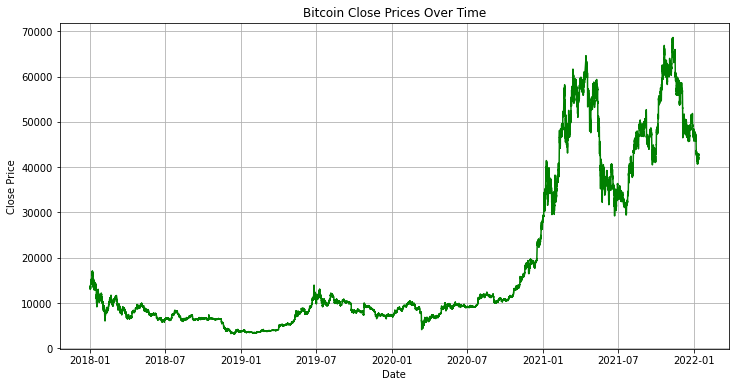

In [6]:
# Convert 'datetime' column to datetime format
btc['datetime'] = pd.to_datetime(btc['datetime'])

# Set 'datetime' as index
btc.set_index('datetime', inplace=True)

# Plot time series of 'close' prices
plt.figure(figsize=(12, 6))
plt.plot(btc.index, btc['close'], color='green')
plt.title('Bitcoin Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

we can see a long term exponential growth trend.

we can see a clear yearly cyclic trend.

we can see a correlation between COVID-19 event emergence and shoot up of bitcoin prices.

### correlation analysis

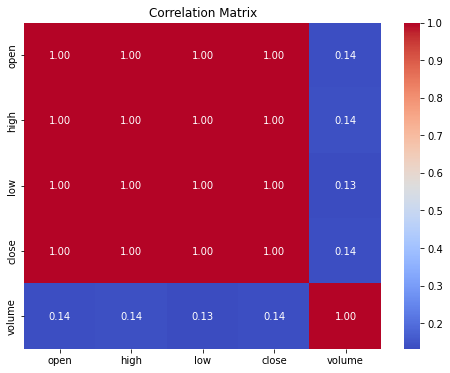

In [7]:
correlation_matrix = btc.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Volume Analysis

to see the relation between trading volume and prices to infer market activity and liquidity

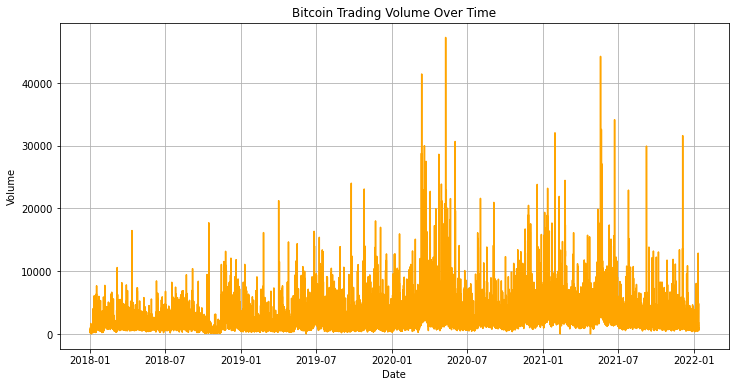

In [8]:
# Plot time series of trading volume
plt.figure(figsize=(12, 6))
plt.plot(btc.index, btc['volume'], color='orange')
plt.title('Bitcoin Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()


### Plotting box plots to find outliers

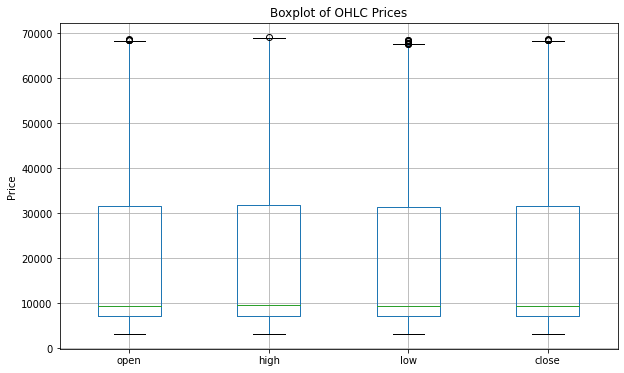

In [9]:
# Boxplot for OHLC prices
btc[['open', 'high', 'low', 'close']].boxplot(figsize=(10, 6))
plt.title('Boxplot of OHLC Prices')
plt.ylabel('Price')
plt.show()

# Data Cleaning

In [10]:
# checking presence of missing values (in this specific data set)

missing_values = btc.isnull().sum()

# Check if there are any missing values
if missing_values.sum() == 0:
    print("No missing values found.")
else:
    print("Missing values found.")
    print(missing_values)


No missing values found.


### for any general dataset we'll check for missing values and do mean imputation

Used scheme:

2 neighbour mean imputation for O, C and V.

5 neighbour max imputation for H.

5 neighbour min imputation for L.

Note Compare the max with the current sample O C V and take the max one as imputed H

In [11]:
# missing values before imputation
missing_values_before_imputation = btc.isnull().sum()
print("Missing values before imputation:")
print(missing_values_before_imputation)

def impute_missing_values(df):
    # Impute missing values for 'open' and 'close' columns using 2 neighborhood mean imputation
    df['open'] = df['open'].fillna(df['open'].rolling(window=3, min_periods=1, center=True).mean())
    df['close'] = df['close'].fillna(df['close'].rolling(window=3, min_periods=1, center=True).mean())
    
    # Impute missing values for 'volume' column using 2 neighborhood mean imputation
    df['volume'] = df['volume'].fillna(df['volume'].rolling(window=3, min_periods=1, center=True).mean())
    
    # Impute missing values for 'high' column using 5 neighborhood mode/max value imputation
    df['high'] = df['high'].fillna(df['high'].rolling(window=5, min_periods=1, center=True).max())
    
    # Impute missing values for 'low' column using 5 neighborhood minimum value imputation
    df['low'] = df['low'].fillna(df['low'].rolling(window=5, min_periods=1, center=True).min())
    
    return df

# Apply imputation function to the DataFrame
btc = impute_missing_values(btc)

# Verify that there are no missing values after imputation
missing_values_after_imputation = btc.isnull().sum()
print("Missing values after imputation:")
print(missing_values_after_imputation)


Missing values before imputation:
open      0
high      0
low       0
close     0
volume    0
dtype: int64
Missing values after imputation:
open      0
high      0
low       0
close     0
volume    0
dtype: int64


### checking for anomalies and updating

H should be the highest in OHLC and L should be the lowest.

If it is not then there is an Anomaly.

we're removing anomaly by minimum/maximum correction


In [12]:
# Check if high (H) price is the highest among O, L, H, and C
fallacy_high_indices = btc.index[btc['high'] < btc[['open', 'low', 'close']].max(axis=1)]

# Update high (H) price using maximum correction
btc.loc[fallacy_high_indices, 'high'] = btc[['open', 'low', 'close']].max(axis=1)

# Check if low (L) price is the lowest among O, L, H, and C
fallacy_low_indices = btc.index[btc['low'] > btc[['open', 'high', 'close']].min(axis=1)]

# Combine indices of anomalies
all_fallacy_indices = fallacy_high_indices.union(fallacy_low_indices)

print("Number of anomalies detected:", len(all_fallacy_indices))

# Update low (L) price using minimum correction
btc.loc[fallacy_low_indices, 'low'] = btc[['open', 'high', 'close']].min(axis=1)

print("Anomalies corrected successfully using maximum/minimum correction.")


Number of anomalies detected: 0
Anomalies corrected successfully using maximum/minimum correction.


### OUTLIERS

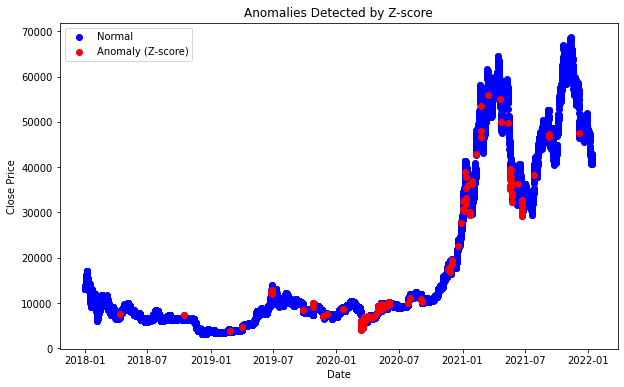

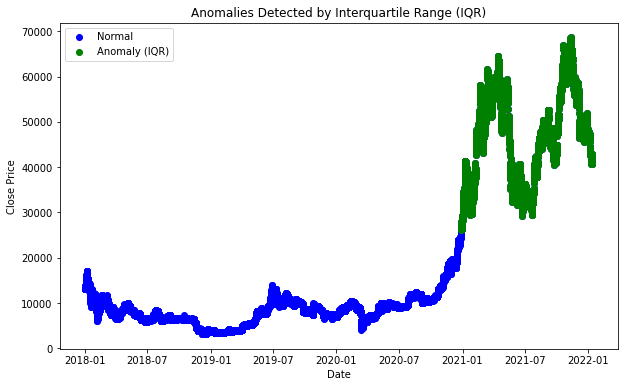

In [17]:
# Function to detect outliers using z-score
def detect_outliers_zscore(data, threshold=6):
    z_scores = zscore(data)
    return np.abs(z_scores) > threshold

# Function to detect outliers using interquartile range (IQR)
def detect_outliers_iqr(data):
    quartile_1, quartile_3 = np.percentile(data, [25, 75])
    iqr_value = quartile_3 - quartile_1
    lower_bound = quartile_1 - (1.5 * iqr_value)
    upper_bound = quartile_3 + (1.5 * iqr_value)
    return (data < lower_bound) | (data > upper_bound)

# Example usage
# Assuming 'btc' DataFrame contains the OHLCV data

# Detect outliers using z-score
outliers_zscore = detect_outliers_zscore(btc[['open', 'high', 'low', 'close', 'volume']])

# Detect outliers using IQR
outliers_iqr = detect_outliers_iqr(btc[['open', 'high', 'low', 'close', 'volume']])

plt.figure(figsize=(10, 6))
plt.scatter(btc.index, btc['close'], color='blue', label='Normal')
plt.scatter(btc[outliers_zscore]['close'].index, btc[outliers_zscore]['close'], color='red', label='Anomaly (Z-score)')
plt.title('Anomalies Detected by Z-score')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plot anomalies detected by IQR
plt.figure(figsize=(10, 6))
plt.scatter(btc.index, btc['close'], color='blue', label='Normal')
plt.scatter(btc[outliers_iqr]['close'].index, btc[outliers_iqr]['close'], color='green', label='Anomaly (IQR)')
plt.title('Anomalies Detected by Interquartile Range (IQR)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

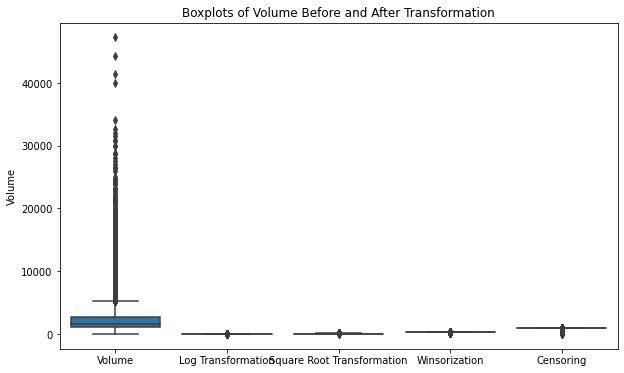

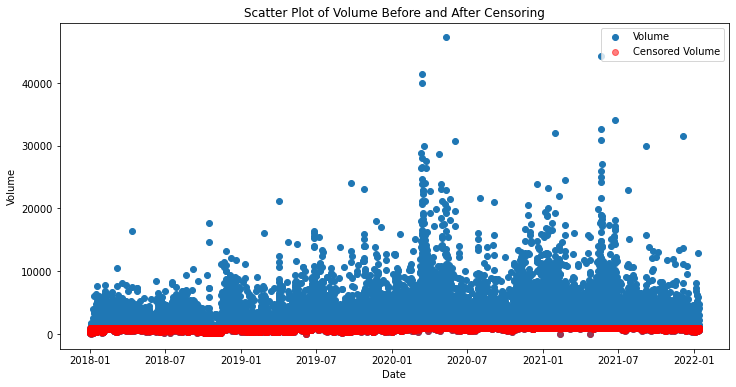

In [14]:

# Function to apply log transformation
def apply_log_transformation(data):
    return np.log1p(data)

# Function to apply square root transformation
def apply_sqrt_transformation(data):
    return np.sqrt(data)

# Function to apply winsorization
def apply_winsorization(data, lower_limit=0.05, upper_limit=0.95):
    lower_bound = np.percentile(data, lower_limit)
    upper_bound = np.percentile(data, upper_limit)
    return np.clip(data, lower_bound, upper_bound)

# Function to apply censoring
def apply_censoring(data, min_threshold, max_threshold):
    return np.clip(data, min_threshold, max_threshold)

# Apply log transformation to 'volume' column
btc['volume_log'] = apply_log_transformation(btc['volume'])

# Apply square root transformation to 'volume' column
btc['volume_sqrt'] = apply_sqrt_transformation(btc['volume'])

# Apply winsorization to 'volume' column
btc['volume_winsorized'] = apply_winsorization(btc['volume'])

# Apply censoring to 'volume' column
btc['volume_censored'] = apply_censoring(btc['volume'], min_threshold=0, max_threshold=1000)

# Visualize boxplots before and after transformation
plt.figure(figsize=(10, 6))
sns.boxplot(data=btc[['volume', 'volume_log', 'volume_sqrt', 'volume_winsorized', 'volume_censored']])
plt.title('Boxplots of Volume Before and After Transformation')
plt.ylabel('Volume')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['Volume', 'Log Transformation', 'Square Root Transformation', 'Winsorization', 'Censoring'])
plt.show()

# Visualize scatter plot before and after transformation
plt.figure(figsize=(12, 6))
plt.scatter(btc.index, btc['volume'], label='Volume')
plt.scatter(btc.index, btc['volume_censored'], label='Censored Volume', color='red', alpha=0.5)
plt.title('Scatter Plot of Volume Before and After Censoring')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

### Normalization


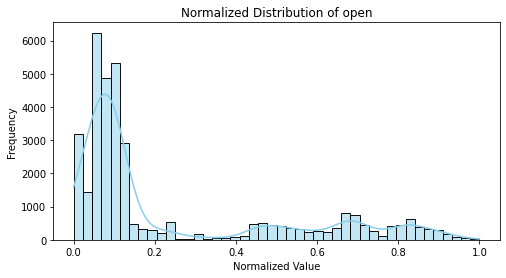

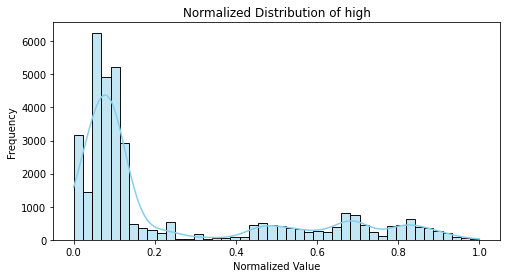

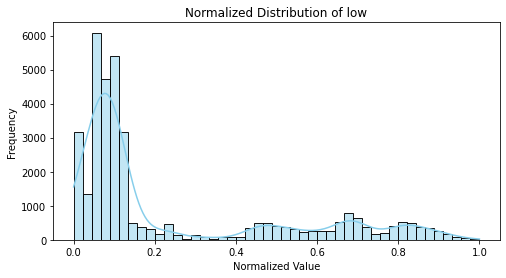

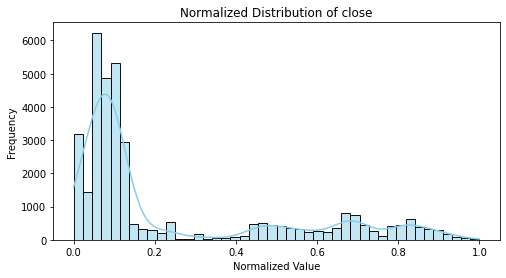

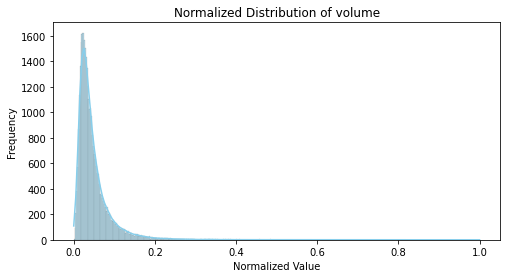

In [15]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select the columns to be normalized (excluding datetime column)
columns_to_normalize = ['open', 'high', 'low', 'close', 'volume']

# Normalize the selected columns
btc_normalized = btc.copy()  # Create a copy of the DataFrame to avoid modifying the original data
btc_normalized[columns_to_normalize] = scaler.fit_transform(btc_normalized[columns_to_normalize])

# Plot the normalized data for each column to visualize the distribution
for column in columns_to_normalize:
    plt.figure(figsize=(8, 4))
    sns.histplot(btc_normalized[column], kde=True, color='skyblue')
    plt.title(f'Normalized Distribution of {column}')
    plt.xlabel('Normalized Value')
    plt.ylabel('Frequency')
    plt.show()

In [16]:
# Display the normalized DataFrame
print("Normalized DataFrame:")
btc_normalized.head()

Normalized DataFrame:


datetime      open      high       low     close    volume  \
0  2018-01-01 05:30:00  0.161054  0.160007  0.156884  0.158214  0.009382   
1  2018-01-01 06:30:00  0.158203  0.158187  0.153138  0.153235  0.008120   
2  2018-01-01 07:30:00  0.153223  0.155491  0.153821  0.155177  0.009080   
3  2018-01-01 08:30:00  0.155167  0.158421  0.155199  0.156397  0.008890   
4  2018-01-01 09:30:00  0.156767  0.158604  0.155692  0.159314  0.007212   

   volume_log  volume_sqrt  volume_winsorized  volume_censored  
0    6.096626    21.056025         306.654813       443.356199  
1    5.952456    19.588185         306.654813       383.697006  
2    6.063935    20.713874         306.654813       429.064572  
3    6.042840    20.496025         306.654813       420.087030  
4    5.834247    18.460968         306.654813       340.807329

### Normalization and Standardization

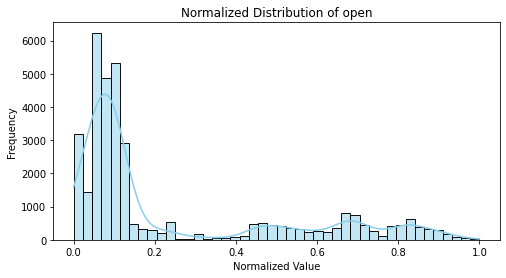

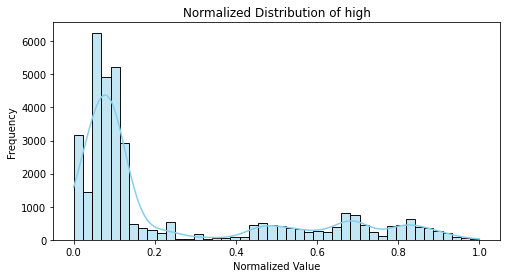

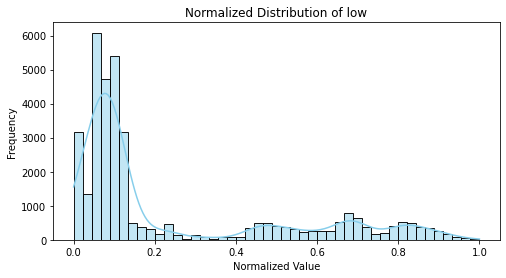

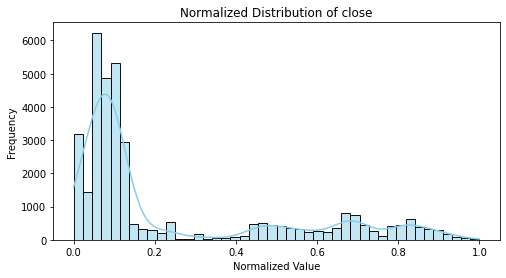

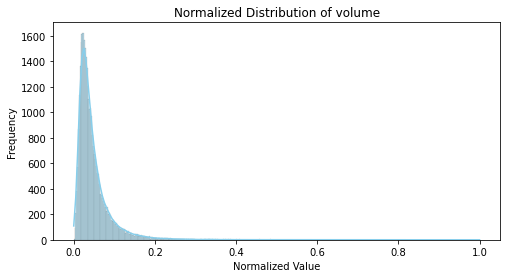

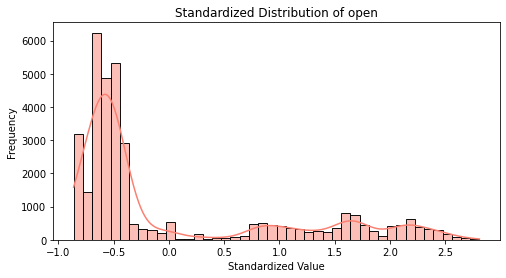

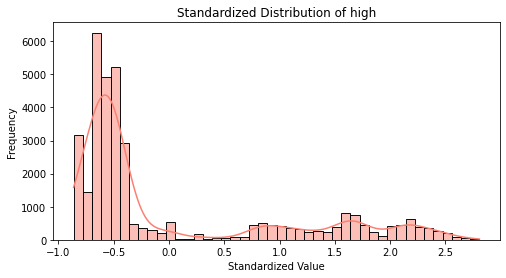

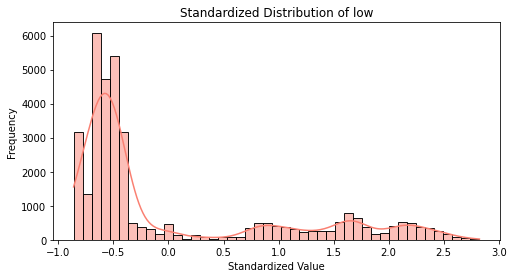

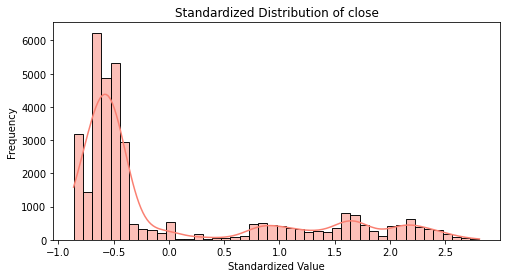

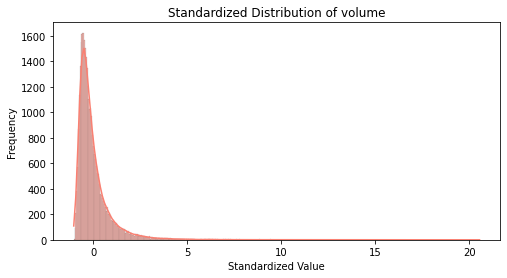

In [17]:
# Initialize MinMaxScaler for normalization
min_max_scaler = MinMaxScaler()

# Initialize StandardScaler for standardization
standard_scaler = StandardScaler()

# Select the columns to be normalized and standardized (excluding datetime column)
columns_to_process = ['open', 'high', 'low', 'close', 'volume']

# Normalize the selected columns
btc_normalized = btc.copy()  # Create a copy of the DataFrame to avoid modifying the original data
btc_normalized[columns_to_process] = min_max_scaler.fit_transform(btc_normalized[columns_to_process])

# Standardize the selected columns
btc_normalized_standardized = btc.copy()  # Create a copy of the DataFrame to avoid modifying the original data
btc_normalized_standardized[columns_to_process] = standard_scaler.fit_transform(btc_normalized_standardized[columns_to_process])

# Visualize the distribution of normalized data
for column in columns_to_process:
    plt.figure(figsize=(8, 4))
    sns.histplot(btc_normalized[column], kde=True, color='skyblue')
    plt.title(f'Normalized Distribution of {column}')
    plt.xlabel('Normalized Value')
    plt.ylabel('Frequency')
    plt.show()

# Visualize the distribution of standardized data
for column in columns_to_process:
    plt.figure(figsize=(8, 4))
    sns.histplot(btc_normalized_standardized[column], kde=True, color='salmon')
    plt.title(f'Standardized Distribution of {column}')
    plt.xlabel('Standardized Value')
    plt.ylabel('Frequency')
    plt.show()

In [18]:
btc_normalized_standardized.head()

datetime      open      high       low     close    volume  \
0  2018-01-01 05:30:00 -0.270629 -0.275122 -0.283534 -0.281139 -0.839447   
1  2018-01-01 06:30:00 -0.281101 -0.281801 -0.297347 -0.299426 -0.866711   
2  2018-01-01 07:30:00 -0.299390 -0.291697 -0.294828 -0.292294 -0.845979   
3  2018-01-01 08:30:00 -0.292251 -0.280943 -0.289746 -0.287814 -0.850081   
4  2018-01-01 09:30:00 -0.286376 -0.280273 -0.287930 -0.277100 -0.886311   

   volume_log  volume_sqrt  volume_winsorized  volume_censored  
0    6.096626    21.056025         306.654813       443.356199  
1    5.952456    19.588185         306.654813       383.697006  
2    6.063935    20.713874         306.654813       429.064572  
3    6.042840    20.496025         306.654813       420.087030  
4    5.834247    18.460968         306.654813       340.807329

### Skewness and Kurtosis

To handle skewed data

Skewness of open: 1.2694005239840553
Kurtosis of open: 0.05865284708481333


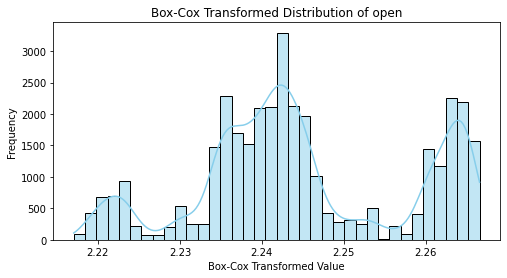

Skewness of high: 1.2666338308959058
Kurtosis of high: 0.048465642052586855


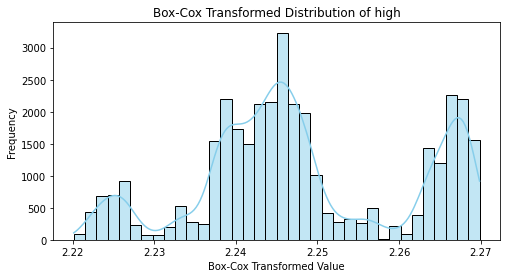

Skewness of low: 1.2724662388920418
Kurtosis of low: 0.0696873850962243


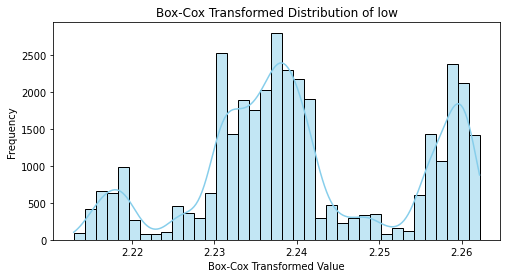

Skewness of close: 1.2692370452057788
Kurtosis of close: 0.058204833277008206


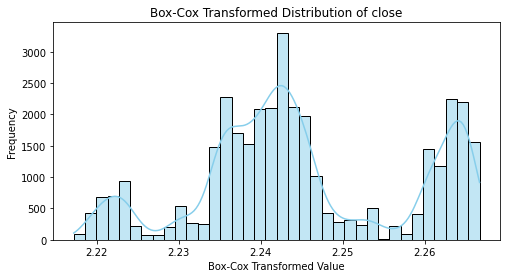

Skewness of volume: 4.562110227055695
Kurtosis of volume: 40.661819214769274


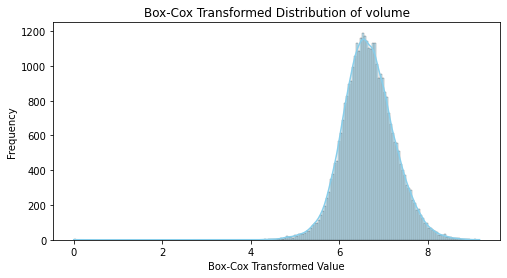

In [19]:
# Select the columns to check for skewness and kurtosis
columns_to_check = ['open', 'high', 'low', 'close', 'volume']

# Function to apply transformations and visualize the distribution
def handle_skewed_data(df, columns):
    for column in columns:
        # Calculate skewness and kurtosis
        skewness = skew(df[column])
        kurt = kurtosis(df[column])

        print(f"Skewness of {column}: {skewness}")
        print(f"Kurtosis of {column}: {kurt}")

        # Check if transformation is necessary
        if abs(skewness) > 0.5 or abs(kurt) > 0.5:
            # Apply Box-Cox transformation if the data is positively skewed
            if skewness > 0:
                transformed_data, _ = boxcox(df[column] + 1)  # Adding 1 to handle zero values
                transformation_type = 'Box-Cox'
            # Apply log transformation if the data is negatively skewed
            else:
                transformed_data = np.log1p(df[column])
                transformation_type = 'Logarithmic'
            
            # Visualize the distribution after transformation
            plt.figure(figsize=(8, 4))
            sns.histplot(transformed_data, kde=True, color='skyblue')
            plt.title(f'{transformation_type} Transformed Distribution of {column}')
            plt.xlabel(f'{transformation_type} Transformed Value')
            plt.ylabel('Frequency')
            plt.show()
        else:
            print(f"No transformation needed for {column}.")
            print("-" * 50)

# Apply transformation to handle skewed data
handle_skewed_data(btc, columns_to_check)

# Statistical transforms to stabilize mean and variance

In [ ]:
btc=pd.read_csv('btcusdt_1h_zelta.csv') # file saved in current location
btc

In [5]:
btc.columns

Index(['datetime', 'open', 'high', 'low', 'close', 'volume'], dtype='object')

In [6]:
btc.head(5)

datetime      open      high       low     close      volume
0  2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01  443.356199
1  2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06  383.697006
2  2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18  429.064572
3  2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03  420.087030
4  2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01  340.807329

In [7]:
# Define exponential_smoothing function
def exponential_smoothing(series, alpha):
    model = SimpleExpSmoothing(series)
    fit_model = model.fit(smoothing_level=alpha, optimized=False)
    return fit_model.fittedvalues

# Function to apply log transformation
def apply_log_transformation(data):
    return np.log1p(data)

# Function to apply winsorization
def apply_winsorization(data, lower_limit=0.05, upper_limit=0.95):
    lower_bound = np.percentile(data, lower_limit)
    upper_bound = np.percentile(data, upper_limit)
    return np.clip(data, lower_bound, upper_bound)


In [8]:
btc['og_close'] = btc['close']

In [9]:
# Apply log transformation to 'volume' column
btc['volume_log'] = apply_log_transformation(btc['volume'])

# Apply winsorization to 'volume' column
btc['volume_winsorized'] = apply_winsorization(btc['volume'])

In [10]:
scaler = MinMaxScaler()

# Select the columns to be normalized (excluding datetime column)
columns_to_normalize = ['open', 'high', 'low', 'close', 'volume']

# Normalize the selected columns
#btc_normalized = btc.copy()  # Create a copy of the DataFrame to avoid modifying the original data
btc[columns_to_normalize] = scaler.fit_transform(btc[columns_to_normalize])

In [11]:
#btc['close_real'] = btc['close']

# Logarithmic scaling
btc['log_close'] = np.log(btc['og_close'])

# Differencing
btc['diff_close'] = btc['og_close'].diff()

# Box-Cox transformation
btc['boxcox_close'], lambda_value = boxcox(btc['og_close'])

# Exponential smoothing
btc['exp_smooth_close'] = exponential_smoothing(btc['og_close'], alpha=0.2)  # Adjust alpha as needed

# Seasonal decomposition (additive)
result = seasonal_decompose(btc['og_close'], model='additive', period=12)  # Adjust period as needed
btc['seasonal_close_12hrs'] = result.seasonal
result = seasonal_decompose(btc['og_close'], model='additive', period=168)  # Adjust period as needed
btc['seasonal_close_weekly'] = result.seasonal
result = seasonal_decompose(btc['og_close'], model='additive', period=730)  # Adjust period as needed
btc['seasonal_close_monthly'] = result.seasonal
#365/12 * 24
result = seasonal_decompose(btc['og_close'], model='additive', period=2190)  # Adjust period as needed
btc['seasonal_close_quarterly'] = result.seasonal
result = seasonal_decompose(btc['og_close'], model='additive', period=8760)  # Adjust period as needed
btc['seasonal_close_yearly'] = result.seasonal

In [12]:
# 2. Moving Averages
windows = [6, 12, 24]  # Window sizes for moving averages
for window in windows:
    btc[f'moving_avg_{window}'] = btc['og_close'].rolling(window=window).mean()

# 3. Exponential Moving Averages (EMA)
for window in windows:
    btc[f'ema_{window}'] = btc['og_close'].ewm(span=window, min_periods=window).mean()

# 4. Relative Strength Index (RSI)
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

btc['rsi'] = calculate_rsi(btc['og_close'])

# 5. Volatility Measures
volatility_windows = [6, 12, 24]  # Window sizes for volatility measures
for window in volatility_windows:
    btc[f'std_dev_{window}'] = btc['og_close'].rolling(window=window).std()

In [13]:
# 6. Trend Indicators
# Example: MACD (Moving Average Convergence Divergence)
short_window = 12
long_window = 26
signal_window = 9

# Calculate short and long exponential moving averages
btc['ema_short'] = btc['og_close'].ewm(span=short_window, min_periods=short_window).mean()
btc['ema_long'] = btc['og_close'].ewm(span=long_window, min_periods=long_window).mean()

# Calculate MACD line
btc['macd_line'] = btc['ema_short'] - btc['ema_long']

# Calculate signal line (EMA of MACD line)
btc['macd_signal'] = btc['macd_line'].ewm(span=signal_window, min_periods=signal_window).mean()

# 7. Volume Indicators
# Example: Volume Moving Average
volume_window = 6
btc['volume_ma'] = btc['volume'].rolling(window=volume_window).mean()

# 8. Price Rate of Change (ROC)
roc_window = 6
btc['roc'] = (btc['og_close'] - btc['og_close'].shift(roc_window)) / btc['og_close'].shift(roc_window)

# 9. Price Oscillators
# Example: Stochastic Oscillator
k_window = 14
d_window = 3

# Calculate %K
low_min = btc['low'].rolling(window=k_window).min()
high_max = btc['high'].rolling(window=k_window).max()
btc['stochastic_k'] = ((btc['og_close'] - low_min) / (high_max - low_min)) * 100

# Calculate %D (Simple moving average of %K)
btc['stochastic_d'] = btc['stochastic_k'].rolling(window=d_window).mean()

# 10. Seasonality Features
# Example: Day of the week
#btc['day_of_week'] = btc['datetime'].dt.dayofweek

In [14]:
btc['close_volume_interaction'] = btc['og_close'] * btc['volume']

# 12. Technical Analysis Indicators
# Example: Bollinger Bands
window = 20
btc['rolling_mean'] = btc['og_close'].rolling(window=window).mean()
btc['rolling_std'] = btc['og_close'].rolling(window=window).std()
btc['upper_band'] = btc['rolling_mean'] + 2 * btc['rolling_std']
btc['lower_band'] = btc['rolling_mean'] - 2 * btc['rolling_std']

In [15]:
WINDOW_SIZE=6
HORIZON=1

class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers


    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]

    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)

    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [16]:
bitcoin_prices=pd.DataFrame(btc['close'])
bitcoin_prices.rename(columns={'close':'Price'},inplace=True)
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

Price   Price+1   Price+2   Price+3   Price+4   Price+5   Price+6
6   0.162055  0.158672  0.159314  0.156397  0.155177  0.153235  0.158214
7   0.158846  0.162055  0.158672  0.159314  0.156397  0.155177  0.153235
8   0.157771  0.158846  0.162055  0.158672  0.159314  0.156397  0.155177
9   0.159558  0.157771  0.158846  0.162055  0.158672  0.159314  0.156397
10  0.158841  0.159558  0.157771  0.158846  0.162055  0.158672  0.159314

In [17]:
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

In [18]:
df = btc.iloc[6:]
merged_df = pd.concat([df, X], axis=1)
merged_df
X = merged_df

In [20]:
X = X.drop(['datetime'], axis=1)

In [21]:
X

open      high       low     close    volume  og_close  volume_log  \
6      0.158356  0.161289  0.158569  0.162055  0.005608  13780.41    5.583458   
7      0.162038  0.161570  0.159258  0.158846  0.006183  13570.35    5.680817   
8      0.158829  0.160305  0.156884  0.157771  0.005752  13499.99    5.608789   
9      0.157760  0.159313  0.157789  0.159558  0.004509  13616.99    5.366424   
10     0.159777  0.159130  0.158385  0.158841  0.003587  13570.01    5.138807   
...         ...       ...       ...       ...       ...       ...         ...   
35203  0.607973  0.606402  0.605498  0.605367  0.025809  42800.38    7.107099   
35204  0.605308  0.602276  0.604756  0.603211  0.014858  42659.20    6.555505   
35205  0.603278  0.601553  0.604046  0.604034  0.011890  42713.13    6.333031   
35206  0.604018  0.603227  0.604606  0.604281  0.014414  42729.29    6.525238   
35207  0.604265  0.604423  0.603749  0.603452  0.021265  42675.00    6.913645   

       volume_winsorized  log_close  diff_close  ...  rolling_mean  \
6             264.989684   9.531003      221.42  ...           NaN   
7             292.188777   9.515643     -210.06  ...           NaN   
8             271.813553   9.510444      -70.36  ...           NaN   
9             213.095829   9.519074      117.00  ...           NaN   
10            169.512196   9.515617      -46.98  ...           NaN   
...                  ...        ...         ...  ...           ...   
35203         306.654813  10.664302     -171.67  ...    42160.0340   
35204         306.654813  10.660998     -141.18  ...    42196.5530   
35205         306.654813  10.662262       53.93  ...    42223.5210   
35206         306.654813  10.662640       16.16  ...    42246.0865   
35207         306.654813  10.661369      -54.29  ...    42264.6040   

       rolling_std    upper_band    lower_band   Price+1   Price+2   Price+3  \
6              NaN           NaN           NaN  0.158672  0.159314  0.156397   
7              NaN           NaN           NaN  0.162055  0.158672  0.159314   
8              NaN           NaN           NaN  0.158846  0.162055  0.158672   
9              NaN           NaN           NaN  0.157771  0.158846  0.162055   
10             NaN           NaN           NaN  0.159558  0.157771  0.158846   
...            ...           ...           ...       ...       ...       ...   
35203   411.081220  42982.196439  41337.871561  0.607990  0.604674  0.601527   
35204   421.763319  43040.079638  41353.026362  0.605367  0.607990  0.604674   
35205   437.191330  43097.903660  41349.138340  0.603211  0.605367  0.607990   
35206   451.561116  43149.208731  41342.964269  0.604034  0.603211  0.605367   
35207   461.571716  43187.747432  41341.460568  0.604281  0.604034  0.603211   

        Price+4   Price+5   Price+6  
6      0.155177  0.153235  0.158214  
7      0.156397  0.155177  0.153235  
8      0.159314  0.156397  0.155177  
9      0.158672  0.159314  0.156397  
10     0.162055  0.158672  0.159314  
...         ...       ...       ...  
35203  0.603914  0.589076  0.587672  
35204  0.601527  0.603914  0.589076  
35205  0.604674  0.601527  0.603914  
35206  0.607990  0.604674  0.601527  
35207  0.605367  0.607990  0.604674  

[35202 rows x 46 columns]

In [22]:
mergeded_df = pd.concat([X, y], axis=1)
mergeded_df.head()

open      high       low     close    volume  og_close  volume_log  \
6   0.158356  0.161289  0.158569  0.162055  0.005608  13780.41    5.583458   
7   0.162038  0.161570  0.159258  0.158846  0.006183  13570.35    5.680817   
8   0.158829  0.160305  0.156884  0.157771  0.005752  13499.99    5.608789   
9   0.157760  0.159313  0.157789  0.159558  0.004509  13616.99    5.366424   
10  0.159777  0.159130  0.158385  0.158841  0.003587  13570.01    5.138807   

    volume_winsorized  log_close  diff_close  ...  rolling_std  upper_band  \
6          264.989684   9.531003      221.42  ...          NaN         NaN   
7          292.188777   9.515643     -210.06  ...          NaN         NaN   
8          271.813553   9.510444      -70.36  ...          NaN         NaN   
9          213.095829   9.519074      117.00  ...          NaN         NaN   
10         169.512196   9.515617      -46.98  ...          NaN         NaN   

    lower_band   Price+1   Price+2   Price+3   Price+4   Price+5   Price+6  \
6          NaN  0.158672  0.159314  0.156397  0.155177  0.153235  0.158214   
7          NaN  0.162055  0.158672  0.159314  0.156397  0.155177  0.153235   
8          NaN  0.158846  0.162055  0.158672  0.159314  0.156397  0.155177   
9          NaN  0.157771  0.158846  0.162055  0.158672  0.159314  0.156397   
10         NaN  0.159558  0.157771  0.158846  0.162055  0.158672  0.159314   

       Price  
6   0.162055  
7   0.158846  
8   0.157771  
9   0.159558  
10  0.158841  

[5 rows x 47 columns]

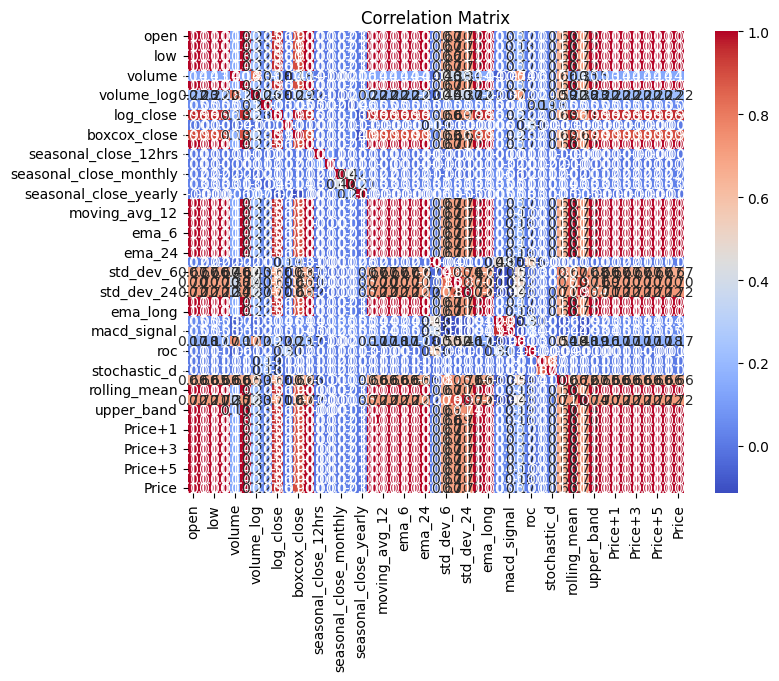

In [23]:
correlation_matrix = mergeded_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [24]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(28161, 28161, 7041, 7041)

In [25]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

features_dataset = tf.data.Dataset.from_tensor_slices(X)
labels_dataset = tf.data.Dataset.from_tensor_slices(y)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)


train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))


BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
features_dataset = features_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
labels_dataset = labels_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 46), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 46), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [27]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
NUM_ENGINEERED_FEATURES = 40

INPUT_SIZE = WINDOW_SIZE + NUM_ENGINEERED_FEATURES
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(46, 47)

In [28]:
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")


stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")


backcast, forecast = nbeats_block_layer(stack_input)

residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")


for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")


model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")


model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

Epoch 1/5000
28/28 [==============================] - 16s 176ms/step - loss: 120292.3047 - mae: 120292.3047 - mse: 509714694144.0000 - val_loss: 0.5080 - val_mae: 0.5080 - val_mse: 0.2796 - lr: 0.0010
Epoch 2/5000
28/28 [==============================] - 2s 82ms/step - loss: 0.1030 - mae: 0.1030 - mse: 0.0233 - val_loss: 0.4576 - val_mae: 0.4576 - val_mse: 0.2309 - lr: 0.0010
Epoch 3/5000
28/28 [==============================] - 2s 70ms/step - loss: 0.1497 - mae: 0.1497 - mse: 0.0412 - val_loss: 0.5676 - val_mae: 0.5676 - val_mse: 0.3437 - lr: 0.0010
Epoch 4/5000
28/28 [==============================] - 2s 71ms/step - loss: 0.0919 - mae: 0.0919 - mse: 0.0221 - val_loss: 0.4886 - val_mae: 0.4886 - val_mse: 0.2602 - lr: 0.0010
Epoch 5/5000
28/28 [==============================] - 2s 70ms/step - loss: 0.1420 - mae: 0.1420 - mse: 0.0398 - val_loss: 0.5966 - val_mae: 0.5966 - val_mse: 0.3774 - lr: 0.0010
Epoch 6/5000
28/28 [==============================] - 2s 81ms/step - loss: 0.0840 - mae

In [29]:
def make_pred(model,input_data):
    pseudo_forecast=model.predict(input_data)
    return tf.squeeze(pseudo_forecast)

In [30]:
model_7_preds=make_pred(model_7,features_dataset)

35/35 [==============================] - 2s 20ms/step


In [31]:
def mean_absolute_scaled_error(y_true,y_pred):
    mae=tf.reduce_mean(tf.abs(np.array(y_true)-np.array(y_pred)))
    mae_naive_noseason=tf.reduce_mean(tf.abs(np.array(y_true[1:])-np.array(y_true[:-1])))
    return mae/mae_naive_noseason

In [32]:
def evaluate_model(y_true,y_pred):
    y_true=np.array(y_true)
    y_pred=np.array(y_pred)
    mae=tf.keras.metrics.mean_absolute_error(y_true,y_pred)
    mse=tf.keras.metrics.mean_squared_error(y_true,y_pred)
    rmse=np.sqrt(mse.numpy())
    mape=tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
    mase=mean_absolute_scaled_error(y_true,y_pred)
    return{'mae':mae.numpy(),
           'mse':mse.numpy(),
           'rmse':rmse,
           'mape':mape.numpy(),
           'mase':mase.numpy()}



In [33]:
evaluate_model(y_true=y,y_pred=model_7_preds)

{'mae': 0.22466727,
 'mse': 0.07417859,
 'rmse': 0.27235746,
 'mape': 7011.187,
 'mase': 142.5334638300854}